In [0]:
import pickle
import numpy as np
from sklearn.utils import shuffle

Using Google Colab for training,  next 4 blocks are for uploading the training dataset

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1ajCMiUI6Wv8QdpYmtbcM--U4RTFVH6zq' 

In [4]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1ajCMiUI6Wv8QdpYmtbcM--U4RTFVH6zq


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('trainimg.pkl')  
# Dataset is now stored in a Pandas Dataframe

Unpickling the dataset

In [0]:
pickle_off = open("trainimg.pkl","rb")
emp = pickle.load(pickle_off)

In [0]:
len(emp[0])

784

Reshaping the list as per image dimensions and displaying an example

In [0]:
x_train=np.array(emp)

In [0]:
x_train=x_train.reshape((8000,28,28,1))

In [0]:
x_validate=x_train[6360:]

In [0]:
img_tensor=x_train[2]

In [0]:
img_tensor=img_tensor.reshape((28,28))

In [0]:
img_tensor = np.expand_dims(img_tensor, axis=0)

In [0]:
from keras.preprocessing import image
from keras import activations
from matplotlib import pyplot as plt
%matplotlib inline

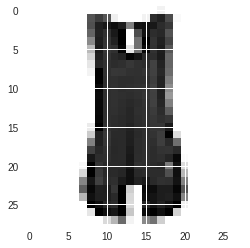

In [0]:
plt.imshow(img_tensor)

Downloading the training labels

In [0]:
link = 'https://drive.google.com/open?id=1CjWhqbqViHgS7ti5dajfiwC36qupwlhw' 

In [11]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1CjWhqbqViHgS7ti5dajfiwC36qupwlhw


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('trainlabel.pkl')  
# Dataset is now stored in a Pandas Dataframe

In [0]:
pickle_off = open("trainlabel.pkl","rb")
emp = pickle.load(pickle_off)


In [0]:
y_train=np.array(emp)

In [15]:
y_train.shape

(8000,)

In [0]:
y_train=y_train.reshape((8000,1))

shuffling the dataset


In [0]:
x_train, y_train = shuffle(x_train, y_train, random_state=0)

Downloading the test images

In [0]:
link = 'https://drive.google.com/open?id=16rGDv7syd_gR5xIBgHvflMehePTBCDmy' 

In [20]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

16rGDv7syd_gR5xIBgHvflMehePTBCDmy


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('testimg.pkl')  
# Dataset is now stored in a Pandas Dataframe

In [0]:
pickle_off = open("testimg.pkl","rb")
emp = pickle.load(pickle_off)


In [0]:
len(emp)

2000

In [0]:
x_test=np.array(emp)

In [0]:
x_test=x_test.reshape((2000,28,28,1))

In [25]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


Changing class values to be able to use to_categorically

In [26]:
np.unique(y_train)

array([0, 2, 3, 6])

In [0]:
y_train[y_train==2]=1

In [0]:
y_train[y_train==3]=2

In [0]:
y_train[y_train==6]=3
    

In [0]:
y_train = keras.utils.to_categorical(y_train, 4)

In [36]:
y_train.shape

(8000, 4)

Creating validation set

In [0]:
x_validate=x_train[6360:]

In [0]:
y_validate=y_train[6360:]

In [38]:
y_validate.shape

(1640, 4)

preprocessing the pixel values

In [0]:
x_train=x_train/255

In [0]:
x_train = (x_train - 0.5) * 2

In [0]:
x_test=x_test/255

In [0]:
x_test = (x_test - 0.5) * 2

In [0]:
x_validate=x_validate/255

In [0]:
x_validate = (x_validate - 0.5) * 2

building a simple convolutional module

In [0]:
from keras.layers import GlobalAveragePooling2D 

In [46]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax')) 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [0]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Training the model

Earlier I had tried training the model on unshuffled data but that gave me very poor validation accuracy around 30%. I have experienced similar problem in the past with smaller datasets where the model is not able to generalise the feauture due to uneven distribution. After shuffling I was able to achieve high validation accuracy

In [49]:
model.fit(x_train[:6360], y_train[:6360],
          batch_size=25,
          epochs=50,
          verbose=1,validation_data=(x_validate,y_validate),shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 6360 samples, validate on 1640 samples
Epoch 1/50
6360/6360 [==============================] - 8s 1ms/step - loss: 0.6411 - acc: 0.7395 - val_loss: 0.5402 - val_acc: 0.7841
Epoch 2/50
6360/6360 [==============================] - 3s 462us/step - loss: 0.4510 - acc: 0.8258 - val_loss: 0.4283 - val_acc: 0.8293
Epoch 3/50
6360/6360 [==============================] - 3s 451us/step - loss: 0.3995 - acc: 0.8436 - val_loss: 0.3845 - val_acc: 0.8488
Epoch 4/50
6360/6360 [==============================] - 3s 449us/step - loss: 0.3536 - acc: 0.8610 - val_loss: 0.3521 - val_acc: 0.8659
Epoch 5/50
6360/6360 [==============================] - 3s 449us/step - loss: 0.3199 - acc: 0.8785 - val_loss: 0.3835 - val_acc: 0.8628
Epoch 6/50
6360/6360 [==============================] - 3s 451us/step - loss: 0.2896 - acc: 0.8865 - val_loss: 0.3434 - val_acc: 0.8640
Epoch 7/50
6360/6360 [==============================] - 3s 445us/step - loss: 0.2638 - acc

In [0]:
labels=[]

predicitng the test labels

In [0]:
y_prob=model.predict(x_test)

In [0]:
y_labels=y_prob.argmax(axis=-1)

In [53]:
np.unique(y_labels)

array([0, 1, 2, 3])

In [0]:
y_labels[y_labels==3]=6

In [0]:
y_labels[y_labels==2]=3

In [0]:
y_labels[y_labels==1]=2
    

In [57]:
np.unique(y_labels)

array([0, 2, 3, 6])

sending labels to dataframe and producing csv

In [0]:
import csv
import pandas as pd

In [0]:
df=pd.DataFrame(columns=['image_index','class'])

In [0]:
for i in range (0,2000):
  df.loc[i]=[i,y_labels[i]]

In [61]:
df.head()

,image_index,class
0,0,0
1,1,6
2,2,0
3,3,0
4,4,0


In [0]:
df.to_csv('Ayush_Agarwal.csv', sep=',', encoding='utf-8',index=False)